In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=10, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)



In [5]:
resolution_human = 1000
species = "human"
SRP_name = "aggregates"
resolution = "1kbp_raw"

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/spr/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'

jac_exp = hm.hiCMatrix(exp_file_path)

all_genes = [x[3].decode() for x in jac_exp.cut_intervals]


f_m = jac_exp.matrix.toarray()

f_m = f_m + abs(f_m.min())

np.fill_diagonal(f_m, 0)

df_exp_corr = pd.DataFrame(f_m ,  index=all_genes, columns = all_genes)
    

In [6]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_exp_corr_pdist = sp.distance.squareform(df_exp_corr)

In [7]:
import numpy as np
from scipy.cluster import hierarchy as hc
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt

In [8]:
import numpy as np
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
 
# Create an array
x = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])
 
# Plot the hierarchical clustering as a dendrogram.

temp = hc.linkage(df_exp_corr_pdist, method='average')

In [78]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(temp,0.05,criterion='distance')

In [79]:
len(list(np.unique(fl)))

14914

In [80]:
from collections import Counter
z = list(fl)
z = Counter(z)

In [81]:
max(z.values())

8538

In [82]:
len([x for x in z.values() if x > 2])

1

In [31]:
z.values()

dict_values([1564, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [15]:
df_exp_clust = pd.DataFrame(fl ,  index=all_genes)

df_exp_clust['label'] = df_exp_clust[0]

for clust in list(range(0,len(list(np.unique(fl))))):
    df_exp_clust[clust] = [1 if x == clust else 0 for x in df_exp_clust['label']]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 4554, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 4562, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 693

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/generic.py", line 3826, in _set_item
    loc = self._info_axis.get_loc(key)
  File "/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/pandas/core/

TypeError: object of type 'NoneType' has no len()

In [12]:
df_exp_clust.sum()[df_exp_clust.sum() > 2]

label    1759781
1          21602
dtype: int64

In [50]:
import sys
sys.setrecursionlimit(100000)

In [ ]:
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=0.2)

In [28]:
temp

array([[ 1.07460000e+04,  2.26250000e+04, -2.97134556e-03,
         2.00000000e+00],
       [ 8.26400000e+03,  9.49000000e+03, -1.57280487e-03,
         2.00000000e+00],
       [ 3.16000000e+03,  1.77720000e+04, -1.55369169e-03,
         2.00000000e+00],
       ...,
       [ 4.49900000e+03,  4.69250000e+04,  2.43343432e-01,
         2.34630000e+04],
       [ 5.58400000e+03,  4.69260000e+04,  2.43646048e-01,
         2.34640000e+04],
       [ 5.58600000e+03,  4.69270000e+04,  2.46495230e-01,
         2.34650000e+04]])

In [11]:
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/spr/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'

jac_exp = hm.hiCMatrix(exp_file_path)


In [12]:
jac_exp 

In [5]:
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [10]:
df_exp_corr 

ENSG00000278267  ENSG00000233750  ENSG00000268903  \
ENSG00000278267         1.000000         0.343890         0.487717   
ENSG00000233750         0.343890         1.000000         0.860658   
ENSG00000268903         0.487717         0.860658         1.000000   
ENSG00000269981         0.504516         0.809451         0.946427   
ENSG00000241860         0.479969         0.673940         0.811533   
...                          ...              ...              ...   
ENSG00000155959         0.276849         0.040029         0.130469   
ENSG00000155961         0.128407         0.128214         0.097678   
ENSG00000155962         0.073441         0.152424         0.278535   
ENSG00000224533         0.334817         0.349970         0.296989   
ENSG00000185973         0.401233         0.185124         0.287707   

                 ENSG00000269981  ENSG00000241860  ENSG00000279928  \
ENSG00000278267         0.504516         0.479969         0.343116   
ENSG00000233750         0.809451         0.673940         0.028341   
ENSG00000268903         0.946427         0.811533         0.065573   
ENSG00000269981         1.000000         0.833857         0.110389   
ENSG00000241860         0.833857         1.000000         0.083856   
...                          ...              ...              ...   
ENSG00000155959         0.077081         0.316597         0.176820   
ENSG00000155961         0.141587         0.323042         0.130175   
ENSG00000155962         0.298601         0.382400         0.077759   
ENSG00000224533         0.386713         0.498483         0.235486   
ENSG00000185973         0.322068         0.724452         0.291270   

                 ENSG00000279457  ENSG00000228463  ENSG00000237094  \
ENSG00000278267         0.896050         0.229694         0.550274   
ENSG00000233750         0.463029         0.399338         0.764022   
ENSG00000268903         0.767021         0.441015         0.856639   
ENSG00000269981         0.656542         0.527122         0.903084   
ENSG00000241860         0.508489         0.340035         0.944649   
...                          ...              ...              ...   
ENSG00000155959         0.678122         0.712112         0.395085   
ENSG00000155961         0.521158         0.579213         0.386790   
ENSG00000155962         0.585610         0.620367         0.564975   
ENSG00000224533         0.667091         0.538497         0.702738   
ENSG00000185973         0.626955         0.728197         0.779498   

                 ENSG00000225972  ...  ENSG00000185010  ENSG00000277203  \
ENSG00000278267         0.208983  ...         0.164307         0.385439   
ENSG00000233750         0.018238  ...         0.036482         0.231122   
ENSG00000268903         0.194718  ...         0.150049         0.649567   
ENSG00000269981         0.067739  ...         0.280591         0.514719   
ENSG00000241860         0.002976  ...         0.433731         0.334044   
...                          ...  ...              ...              ...   
ENSG00000155959         0.093009  ...         0.932798         0.870960   
ENSG00000155961         0.009413  ...         0.772858         0.644082   
ENSG00000155962         0.093091  ...         0.919599         0.646647   
ENSG00000224533         0.010708  ...         0.564739         0.443018   
ENSG00000185973         0.023739  ...         0.924385         0.664635   

                 ENSG00000165775  ENSG00000214827  ENSG00000185515  \
ENSG00000278267         0.298960         0.589250         0.373065   
ENSG00000233750         0.019885         0.179310         0.108605   
ENSG00000268903         0.146318         0.243782         0.220238   
ENSG00000269981         0.059280         0.163406         0.248240   
ENSG00000241860         0.145356         0.526769         0.550166   
...                          ...              ...              ...   
ENSG00000155959         0.999166         0.911992         0.999719   
ENSG00000155961         0.740986 

In [ ]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_exp_corr_pdist = sp.distance.squareform(df_exp_corr)

In [11]:
import numpy as np 
from sklearn.cluster import AgglomerativeClustering

X = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])

#cluster = AgglomerativeClustering(affinity='precomputed', linkage='complete') 
#cluster = AgglomerativeClustering(affinity='precomputed', linkage='average')
cluster = AgglomerativeClustering(affinity='precomputed', linkage='single')
cluster.fit(X)

AgglomerativeClustering(affinity='precomputed', linkage='single')

array([0.3, 0.4, 0.7])

In [13]:
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

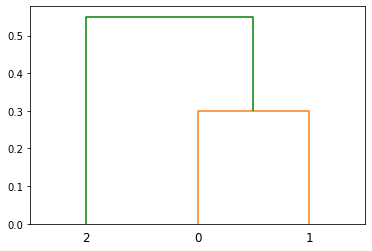

In [33]:
import numpy as np
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
 
# Create an array
x = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])
 
# Plot the hierarchical clustering as a dendrogram.

temp = hc.linkage(sp.distance.squareform(x), method='average')
plt.figure()
 
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=0.5)

In [36]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(temp,0.5,criterion='distance')

In [37]:
fl

array([1, 1, 2], dtype=int32)

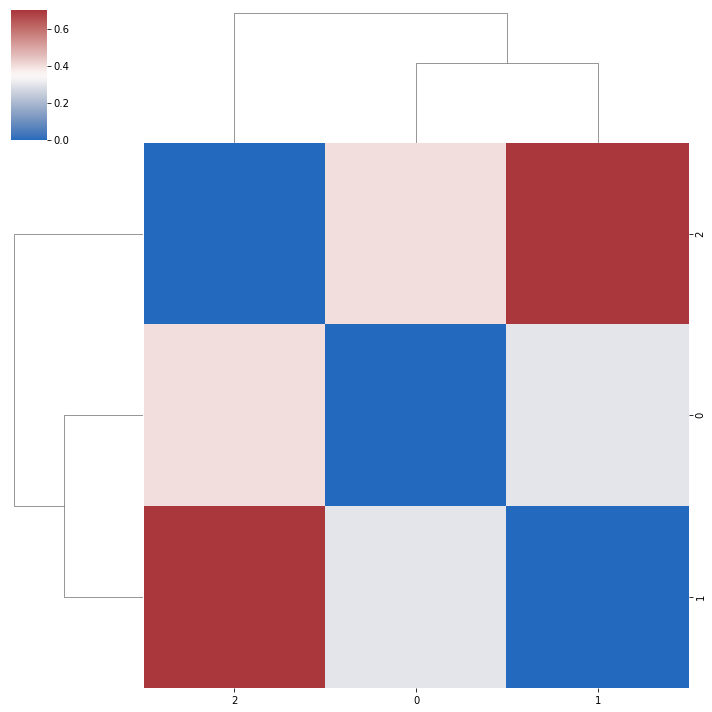

In [25]:
sns.clustermap(x, row_linkage=linkage, col_linkage=linkage, cmap="vlag")

In [20]:
temp

array([[0.  , 1.  , 0.3 , 2.  ],
       [2.  , 3.  , 0.55, 3.  ]])

In [ ]:
import numpy as np
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
 
# Create an array
x = np.array([[0,0.3,0.4],[0.3,0,0.7],[0.4,0.7,0]])
 
# Plot the hierarchical clustering as a dendrogram.

temp = hc.linkage(x, method='average')
plt.figure()
 
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=.7)

In [17]:
temp

array([[0.        , 1.        , 0.51961524, 2.        ],
       [2.        , 3.        , 0.84390388, 3.        ]])

In [6]:
resolution_human = 10000
species = "human"
SRP_name = "aggregates"
resolution = "10kbp_raw"



input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])

In [7]:
    if species == 'human':

        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    else:

        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    df_cre['start_bin'] = df_cre['start']/resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    df_cre['cre'] = 1
    df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    df_cre_1kb_encode = df_cre.merge(bins_bed, left_on='start_bin', right_on='pos')

In [8]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path

In [9]:
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5'

jac_exp = hm.hiCMatrix(exp_file_path)

all_genes = [x[3].decode() for x in jac_exp.cut_intervals]

df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)
    


KeyError: "Unable to open object (object 'matrix' doesn't exist)"